In [7]:
import sys
from pathlib import Path
project_root = Path.cwd().parent
sys.path.append(str(project_root))
from visualization.utils import defaultColors

In [8]:
# from mobo.surrogate_model import BoTorchSurrogateModelReapeat, BoTorchSurrogateModel
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import yaml

In [9]:
from problems.common import get_problem
from mobo.utils import calculate_var
path = Path("../result/peaks/default/qnehvi/0/")


from problems import Peaks, K5

# prob = K5(
#     sigma=0.7,
#     repeat_eval=10
# )

prob = Peaks(
    sigma=0.7,
    repeat_eval=10
)

n_obj = prob.n_obj
bounds = prob.bounds
n = 30

x1 = np.linspace(bounds[0, 0], bounds[1, 0], n)
x2 = np.linspace(bounds[0, 1], bounds[1, 1], n)
x1, x2 = np.meshgrid(x1, x2)
X = np.stack([x1.flatten(), x2.flatten()]).T
Y = prob.f(X).reshape(n, n, 2)
rho_measured = prob._evaluate_rho(X).reshape(n, n, 2)
rho_real = prob.get_noise_var(X).reshape(n, n, 2)
Y_noise = prob._evaluate_F(X).reshape(n, n, 2)

VaR = calculate_var(Y.flatten(), variance=rho_real.flatten())
VaR = VaR.reshape(n, n, 2)

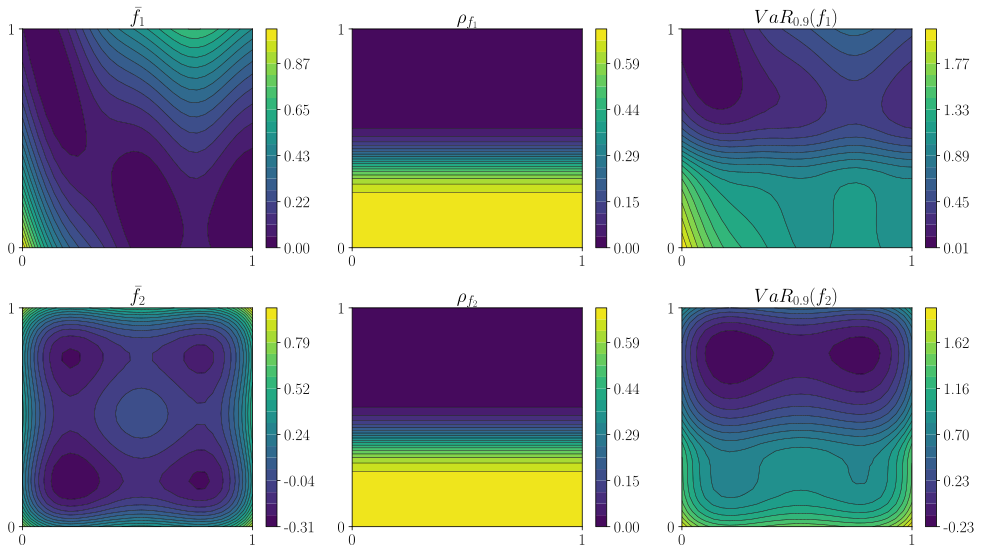

In [11]:
%config InlineBackend.figure_format='svg'
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Helvetica"],
    # font size
    "font.size": 16,
})

colors = defaultColors

objective_list = list(range(1,n_obj+1))
data_keys = ["F_", "rho_F_", "mvar_F_"]

# Y_list = [
#     Y[:, :, 0],
#     Y[:, :, 1],
#     rho_real[:, :, 0],
#     rho_real[:, :, 1],
#     VaR[:, :, 0],
#     VaR[:, :, 1],
# ]

Y_list_dict = {
    "F_1": Y[:, :, 0],
    "F_2": Y[:, :, 1],
    "rho_F_1": rho_real[:, :, 0],
    "rho_F_2": rho_real[:, :, 1],
    "mvar_F_1": VaR[:, :, 0],
    "mvar_F_2": VaR[:, :, 1],
}

x,y = x1, x2

approx_all_i = Y_list_dict

fig, axs = plt.subplots(len(objective_list), len(data_keys), figsize=(14, 8))

for i, obj_idx in enumerate(objective_list):
    for j, key in enumerate(data_keys):
        # Construct the key for the current iteration
        current_key = f"{key}{obj_idx}"
        # Reshape the data for the current plot
        z = approx_all_i[current_key].reshape((n, n))
        levels = np.linspace(z.min(), z.max(), 20)
        # Create contour plot
        img = axs[i, j].contourf(x[0], y[:, 0], z, levels=levels, cmap="viridis")
        c = axs[i, j].contour(x[0], y[:, 0], z, levels=levels, colors='black', linestyles='solid', linewidths=0.5)
        # axs[i, j].clabel(c, c.levels[::2], inline=True, fontsize=10, colors='white', zorder=100)
        
            
        # Latex formatting
        if key == "F_":
            axs[i, j].set_title(f"$\\bar{{f}}_{obj_idx}$")
        if key == "rho_F_":
            axs[i, j].set_title(f"$\\rho_{{f_{obj_idx}}}$")
        if key == "mvar_F_":
            axs[i, j].set_title(f"$VaR_{{0.9}}({{f_{obj_idx}}})$")

        fig.colorbar(img, ax=axs[i,j], orientation='vertical', fraction=0.1, pad=0.05, format="%.2f",
                     ticks=levels[::4])
        
        
# only show axis labels on the bottom row
    
# no axis labels anywhere
for ax in axs.flat:
    ax.set(xticks=[x.min(), x.max()], yticks=[y.min(), y.max()])
    
for ax in axs.flat:
    ax.label_outer()
#one colorbar for all subplots
# fig.colorbar(img, ax=axs, orientation='vertical', fraction=0.05, pad=0.05)

plt.tight_layout()
# plt.show()

path_folder = Path("./Plots") / path.parts[2]
path_folder.mkdir(exist_ok=True, parents=True)
plt.savefig(path_folder / ("_".join(path.parts[3:-1]) + "_IOplotBenchmarkReal.pdf"), dpi=600, format="pdf")

